In [2]:
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import os

In [555]:
species = "fly"
data_gen_mode = ""
seed = 44
results = pd.read_csv(f"./output/{species}_segment_classification{data_gen_mode}_seed{seed}/results.csv")
results["human answer 1"] = [None]*len(results)
results["confidence 1"] = [None]*len(results)

In [556]:
len(results)

139

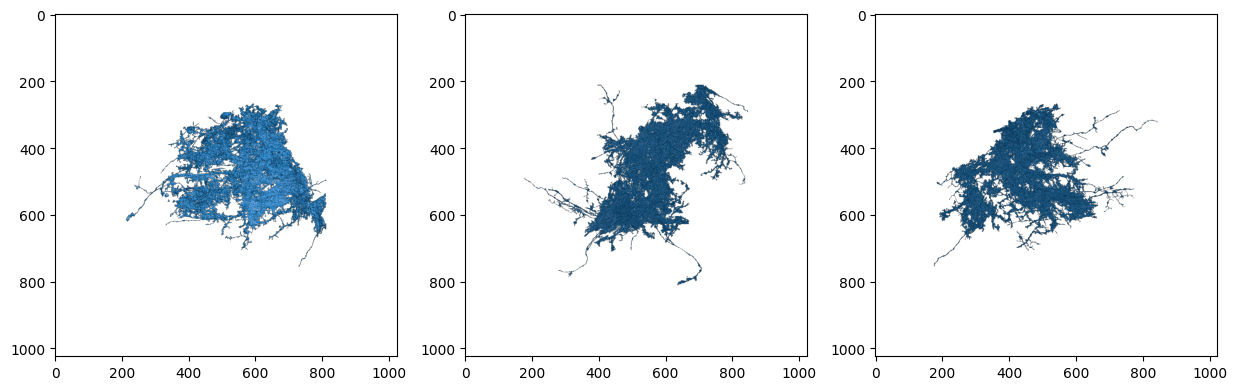

720575940629727488_720575940605338912
BBox size: 108780.0 x 79254.0 x 97188.0 nm
None
None


In [749]:
neuron_idx =91
proofread_root_id = results.iloc[neuron_idx]['proofread root id']
current_root_id = results.iloc[neuron_idx]['current root id']

front_path = f"./output/{species}_segment_classification{data_gen_mode}_seed{seed}/{proofread_root_id}_{current_root_id}_front.png"
side_path = f"./output/{species}_segment_classification{data_gen_mode}_seed{seed}/{proofread_root_id}_{current_root_id}_side.png"
top_path = f"./output/{species}_segment_classification{data_gen_mode}_seed{seed}/{proofread_root_id}_{current_root_id}_top.png"

front_img = np.asarray(Image.open(front_path))
side_img = np.asarray(Image.open(side_path))
top_img = np.asarray(Image.open(top_path))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(front_img)
ax[1].imshow(side_img)
ax[2].imshow(top_img)
plt.show()
print(f"{proofread_root_id}_{current_root_id}")
print(f"BBox size: {results.iloc[neuron_idx]["xmax"] - results.iloc[neuron_idx]["xmin"]} x {results.iloc[neuron_idx]["ymax"] - results.iloc[neuron_idx]["ymin"]} x {results.iloc[neuron_idx]["zmax"] - results.iloc[neuron_idx]["zmin"]} nm")
print(f"{results.loc[neuron_idx, "human answer 1"]}")
print(f"{results.loc[neuron_idx, "confidence 1"]}")


a) A single soma and processes.

b) Multiple somas (and processes)

c) Processes without a soma. These can be axons, dendrites, synapses.

d) Nucleus. 

e) Non-neuronal types. These can be glial cells, blood vessels.

f) None of the above.

g) Unsure

Then, rate your confidence in your answer:

No confidence: 1

Moderately unconfident: 2

Neither confident nor unconfident: 3

Moderately confident: 4

Absolute confidence: 5

In [751]:
answer = "e"
confidence = 3
results.loc[neuron_idx, "human answer 1"] = answer
results.loc[neuron_idx, "confidence 1"] = confidence

# Save the results

In [554]:
results.to_csv(f"./output/{species}_segment_classification{data_gen_mode}_seed{seed}/human_analysis_results.csv", index=False)

# Analyze the results

In [3]:
bboxs = np.array([results['xmax']-results['xmin'], results['ymax']-results['ymin'], results['zmax']-results['zmin']]).T
max_bbox = np.max(bboxs, axis=1)
min_threshold = 500000
max_threshold = 1000000
bbox_exceeds_min_threshold = max_bbox > min_threshold
bbox_less_than_max_threshold = max_bbox < max_threshold

NameError: name 'results' is not defined

In [24]:
analysis_path

'./output/mouse_segment_classification/o4-mini_analysis_results_without_guidance.csv'

In [ ]:
species = "fly"
data_gen_modes = ["", "_first_only"]
prompt_additions = ["", "_without_guidance"]

dfs = []
for data_gen_mode in data_gen_modes:
    dfs.append(pd.read_csv(f"./output/{species}_segment_classification{data_gen_mode}/human_analysis_results.csv"))

human_results = pd.concat(dfs, ignore_index=True)

label_names = ["single neuron", "multiple somas", "processes", "nucleus", "non-neuronal", "none", "unsure"]
labels = ["a", "b", "c", "d", "e", "f", "g"]

opensource_models = ["intern-vl3", "nvlm"]
# models = ["claude-3-7-sonnet-20250219", "gpt-4.1", "gpt-4o", "o4-mini"]
models = ["claude-3-7-sonnet-20250219", "gpt-4.1", "gpt-4o", "o4-mini", "intern-vl3", "nvlm"]
all_human_results = []
for prompt_addition in prompt_additions:
    human_results_copy = human_results.copy()
    for model in models:

        dfs = []
        for data_gen_mode in data_gen_modes:
            if model not in opensource_models:
                analysis_path = f"./output/{species}_segment_classification{data_gen_mode}/{model}_analysis_results{prompt_addition}.csv"
            else:
                analysis_path = f"./output/{species}_segment_classification{data_gen_mode}/{model}_analysis_results{prompt_addition}.csv"

            if not os.path.exists(analysis_path):
                continue
            dfs.append(pd.read_csv(analysis_path))
        if len(dfs) == 0:
            continue
        analysis_results = pd.concat(dfs, ignore_index=True)
        analysis_results.rename(columns ={"proofread_root_id": "proofread root id", "current_root_id": "current root id"}, inplace=True) 
        # analysis_results = pd.read_csv(f"./output/{species}_segment_classification{data_gen_mode}/{model}_analysis_results.csv")
        human_results_copy[f'{model}_llm_answer'] = [None]*len(human_results)
        human_results_copy["prompt_addition"] = prompt_addition       

        for i in range(len(human_results)):
            
            proofread_root_id = human_results_copy.iloc[i]['proofread root id']
            current_root_id = human_results_copy.iloc[i]['current root id']

            ar = analysis_results[(analysis_results['proofread root id'] == proofread_root_id) & (analysis_results['current root id'] == current_root_id)]
            answers = ar['llm_answer']

            formatted_answers = []
            for answer in answers:
                if answer not in labels:
                    formatted_answers.append(answer[:1])
                else:
                    formatted_answers.append(answer)
            answers = formatted_answers
            if len(answers) > 0:
                most_common_answer = Counter(answers).most_common(1)[0][0]
                human_results_copy.loc[i, f'{model}_llm_answer'] = most_common_answer
            else:
                # print("No answers found for", proofread_root_id, current_root_id)
                human_results_copy.loc[i, f'{model}_llm_answer'] = None
    all_human_results.append(human_results_copy)

all_human_results = pd.concat(all_human_results, ignore_index=True)

# human_results.to_csv(f"./output/{species}_segment_classification/human_analysis_results.csv", index=False)

# cm = confusion_matrix(human_results['human answer 1'], human_results['llm_answer'], labels=labels)

{'claude-3-7-sonnet-20250219': np.float64(0.4441378055495703), 'gpt-4.1': np.float64(0.5125878043525103), 'gpt-4o': np.float64(0.4103646244822715), 'o4-mini': np.float64(0.5157126098302569), 'intern-vl3': np.float64(0.1707439488615959), 'nvlm': np.float64(0.10957983193277313)}
claude-3-7-sonnet-20250219: Accuracy: 0.6497326203208557, Balanced accuracy: 0.4441378055495703
gpt-4.1: Accuracy: 0.7379679144385026, Balanced accuracy: 0.5125878043525103
gpt-4o: Accuracy: 0.679144385026738, Balanced accuracy: 0.4103646244822715
o4-mini: Accuracy: 0.679144385026738, Balanced accuracy: 0.5157126098302569
intern-vl3: Accuracy: 0.26737967914438504, Balanced accuracy: 0.1707439488615959
nvlm: Accuracy: 0.18716577540106952, Balanced accuracy: 0.10957983193277313


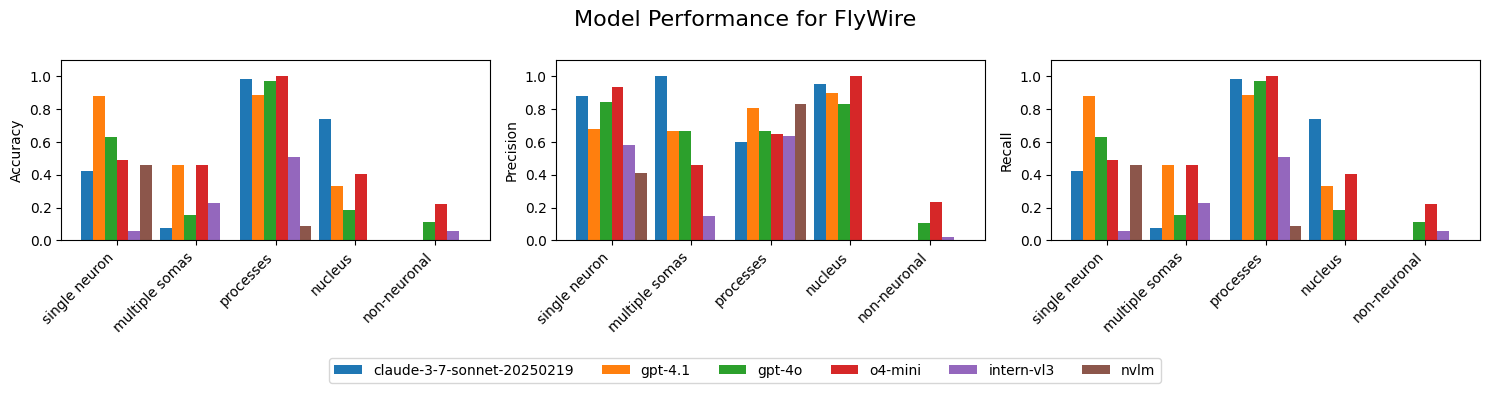

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Define categories and models
categories = ["a", "b", "c", "d", "e"]
label_names = ["single neuron", "multiple somas", "processes", "nucleus", "non-neuronal"]
# models = ["claude-3-7-sonnet-20250219", "gpt-4.1"]#, "gpt-4o", "o4-mini"]
human_results = all_human_results[all_human_results["prompt_addition"] == ""]
totals= []
for category in categories:
    # Count total predictions for this category
    total = sum(human_results["human answer 1"] == category)

    totals.append(total)


# Calculate accuracy for each model and category
accuracies = {}
for model in models:
    model_accuracies = []
    for category in categories:
        # Count correct predictions (where model answer matches human answer)
        correct = sum((human_results[f"{model}_llm_answer"] == human_results["human answer 1"]) & 
                        (human_results["human answer 1"] == category))
        # Count total predictions for this category
        total = sum(human_results["human answer 1"] == category)
        # Calculate accuracy (handle division by zero)
        accuracy = correct / total if total > 0 else 0
        model_accuracies.append(accuracy)
    accuracies[model] = model_accuracies



# Calculate precision for each model and category
precisions = {}
for model in models:
    model_precisions = []
    for category in categories:
        # True positives: model predicted this category and it was correct
        true_positives = sum((human_results[f"{model}_llm_answer"] == category) & 
                            (human_results["human answer 1"] == category))
        # False positives: model predicted this category but it was wrong
        false_positives = sum((human_results[f"{model}_llm_answer"] == category) & 
                            (human_results["human answer 1"] != category))
        # Calculate precision (handle division by zero)
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        model_precisions.append(precision)
    precisions[model] = model_precisions

# Calculate recall for each model and category
recalls = {}
for model in models:
    model_recalls = []
    for category in categories:
        # True positives: model predicted this category and it was correct
        true_positives = sum((human_results[f"{model}_llm_answer"] == category) & 
                            (human_results["human answer 1"] == category))
        # False negatives: model didn't predict this category when it should have
        false_negatives = sum((human_results[f"{model}_llm_answer"] != category) & 
                            (human_results["human answer 1"] == category))
        # Calculate recall (handle division by zero)
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        model_recalls.append(recall)
    recalls[model] = model_recalls
    
balanced_accuracy = {model:np.mean(accuracies[model]) for model in models}
print(balanced_accuracy)
bulk_accuracies = []
for model in models:
    bulk_accuracies.append(sum(human_results[f"{model}_llm_answer"] == human_results["human answer 1"]) / len(human_results))
    print(f"{model}: Accuracy: {bulk_accuracies[-1]}, Balanced accuracy: {balanced_accuracy[model]}")
    

fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # Made figure slightly wider

bar_width = 0.15  # Reduced bar width
base = np.arange(len(categories))
offsets = [base + i * bar_width for i in range(len(models))]
metric_dicts = [accuracies, precisions, recalls]
titles = ["Accuracy", "Precision", "Recall"]

legend_handles = []

for ax, metric, title in zip(axes, metric_dicts, titles):
    for off, model in zip(offsets, models):
        bars = ax.bar(off, metric[model], width=bar_width)
        if title == "Accuracy":
            legend_handles.append(bars[0])

    ax.set_xticks(base + bar_width * (len(models) - 1) / 2)  # Center the x-ticks
    ax.set_xticklabels(label_names, rotation=45, ha="right")
    ax.set_ylim([0, 1.1])
    ax.set_ylabel(title)

fig.legend(legend_handles, models,
           loc="lower center", bbox_to_anchor=(0.5, 0),  # Moved legend down slightly
           ncol=len(models))
species_to_dataset = {"fly": "FlyWire", "mouse": "MICrONS"}
fig.suptitle(f"Model Performance for {species_to_dataset[species]}", fontsize=16, y=0.95)
fig.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjusted layout to prevent legend cutoff
plt.show()





{'claude-3-7-sonnet-20250219': np.float64(0.4579815652756829), 'gpt-4.1': np.float64(0.43983873207402613), 'gpt-4o': np.float64(0.323712035241447), 'o4-mini': np.float64(0.46219990902343844), 'intern-vl3': np.float64(0.0), 'nvlm': np.float64(0.0)}
claude-3-7-sonnet-20250219: Accuracy: 0.6229946524064172, Balanced accuracy: 0.4579815652756829
gpt-4.1: Accuracy: 0.7085561497326203, Balanced accuracy: 0.43983873207402613
gpt-4o: Accuracy: 0.6229946524064172, Balanced accuracy: 0.323712035241447
o4-mini: Accuracy: 0.6844919786096256, Balanced accuracy: 0.46219990902343844
intern-vl3: Accuracy: 0.0, Balanced accuracy: 0.0
nvlm: Accuracy: 0.0, Balanced accuracy: 0.0


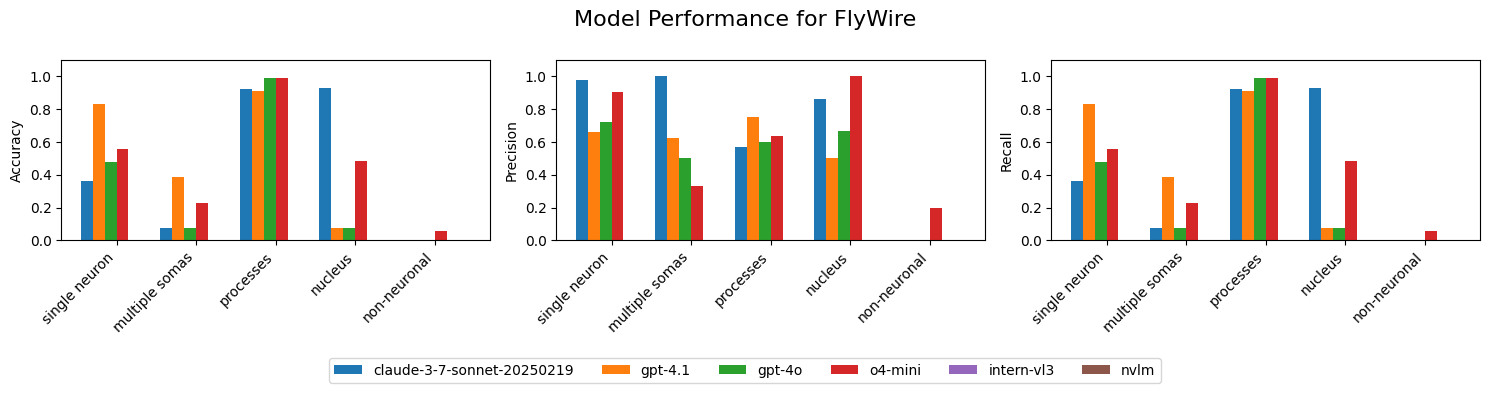

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Define categories and models
categories = ["a", "b", "c", "d", "e"]
label_names = ["single neuron", "multiple somas", "processes", "nucleus", "non-neuronal"]
# models = ["claude-3-7-sonnet-20250219", "gpt-4.1"]#, "gpt-4o", "o4-mini"]
human_results = all_human_results[all_human_results["prompt_addition"] == "_without_guidance"]
totals= []
for category in categories:
    # Count total predictions for this category
    total = sum(human_results["human answer 1"] == category)

    totals.append(total)


# Calculate accuracy for each model and category
accuracies = {}
for model in models:
    model_accuracies = []
    for category in categories:
        # Count correct predictions (where model answer matches human answer)
        correct = sum((human_results[f"{model}_llm_answer"] == human_results["human answer 1"]) & 
                        (human_results["human answer 1"] == category))
        # Count total predictions for this category
        total = sum(human_results["human answer 1"] == category)
        # Calculate accuracy (handle division by zero)
        accuracy = correct / total if total > 0 else 0
        model_accuracies.append(accuracy)
    accuracies[model] = model_accuracies

balanced_accuracy = {model:np.mean(recalls[model]) for model in models}
print(balanced_accuracy)
bulk_accuracies = []
for model in models:
    bulk_accuracies.append(sum(human_results[f"{model}_llm_answer"] == human_results["human answer 1"]) / len(human_results))
    print(f"{model}: Accuracy: {bulk_accuracies[-1]}, Balanced accuracy: {balanced_accuracy[model]}")
    
# Calculate precision for each model and category
precisions = {}
for model in models:
    model_precisions = []
    for category in categories:
        # True positives: model predicted this category and it was correct
        true_positives = sum((human_results[f"{model}_llm_answer"] == category) & 
                            (human_results["human answer 1"] == category))
        # False positives: model predicted this category but it was wrong
        false_positives = sum((human_results[f"{model}_llm_answer"] == category) & 
                            (human_results["human answer 1"] != category))
        # Calculate precision (handle division by zero)
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        model_precisions.append(precision)
    precisions[model] = model_precisions

# Calculate recall for each model and category
recalls = {}
for model in models:
    model_recalls = []
    for category in categories:
        # True positives: model predicted this category and it was correct
        true_positives = sum((human_results[f"{model}_llm_answer"] == category) & 
                            (human_results["human answer 1"] == category))
        # False negatives: model didn't predict this category when it should have
        false_negatives = sum((human_results[f"{model}_llm_answer"] != category) & 
                            (human_results["human answer 1"] == category))
        # Calculate recall (handle division by zero)
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        model_recalls.append(recall)
    recalls[model] = model_recalls
    
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # Made figure slightly wider

bar_width = 0.15  # Reduced bar width
base = np.arange(len(categories))
offsets = [base + i * bar_width for i in range(len(models))]
metric_dicts = [accuracies, precisions, recalls]
titles = ["Accuracy", "Precision", "Recall"]

legend_handles = []

for ax, metric, title in zip(axes, metric_dicts, titles):
    for off, model in zip(offsets, models):
        bars = ax.bar(off, metric[model], width=bar_width)
        if title == "Accuracy":
            legend_handles.append(bars[0])

    ax.set_xticks(base + bar_width * (len(models) - 1) / 2)  # Center the x-ticks
    ax.set_xticklabels(label_names, rotation=45, ha="right")
    ax.set_ylim([0, 1.1])
    ax.set_ylabel(title)

fig.legend(legend_handles, models,
           loc="lower center", bbox_to_anchor=(0.5, 0),  # Moved legend down slightly
           ncol=len(models))
species_to_dataset = {"fly": "FlyWire", "mouse": "MICrONS"}
fig.suptitle(f"Model Performance for {species_to_dataset[species]}", fontsize=16, y=0.95)
fig.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjusted layout to prevent legend cutoff
plt.show()

In [47]:
human_results

,proofread root id,current root id,species,xmin,ymin,zmin,xmax,ymax,zmax,unit,human answer 1,confidence 1,claude-3-7-sonnet-20250219_llm_answer,prompt_addition,gpt-4.1_llm_answer,gpt-4o_llm_answer,o4-mini_llm_answer,intern-vl3_llm_answer,nvlm_llm_answer
374,720575940610675123,720575940617905180,fly,403284.0,201894.0,56322.0,408954.0,206451.0,61551.0,nm,d,NaN,d,_without_guidance,a,a,a,NaN,NaN
375,720575940610675123,720575940630979107,fly,507444.0,180642.0,76818.0,511476.0,185094.0,80892.0,nm,c,NaN,c,_without_guidance,a,c,c,NaN,NaN
376,720575940610675123,720575940621814863,fly,524895.0,183078.0,91161.0,526638.0,187005.0,96852.0,nm,c,NaN,c,_without_guidance,c,c,c,NaN,NaN
377,720575940610675123,720575940619094768,fly,406980.0,120960.0,58380.0,576177.0,203448.0,143850.0,nm,c,NaN,c,_without_guidance,c,c,c,NaN,NaN
378,720575940610675123,720575940610675123,fly,403284.0,167265.0,56280.0,541611.0,206451.0,108255.0,nm,a,NaN,a,_without_guidance,a,a,a,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,720575940628582915,720575940637258611,fly,456372.0,136584.0,57729.0,510300.0,167769.0,87024.0,nm,c,5.0,c,_without_guidance,c,c,c,NaN,NaN
744,720575940628673783,720575940615962552,fly,223944.0,225876.0,180096.0,238938.0,282135.0,200067.0,nm,c,5.0,c,_without_guidance,c,c,c,NaN,NaN
745,720575940628673783,720575940632896334,fly,236838.0,203007.0,169638.0,242529.0,226086.0,182448.0,nm,a,5.0,a,_without_guidance,a,a,c,NaN,NaN
746,720575940628911415,720575940622834190,fly,434826.0,281967.0,135093.0,553203.0,353346.0,251664.0,nm,c,1.0,c,_without_guidance,a,c,c,NaN,NaN
